# Paso 1 | Preparacion e Inicializacion

## Paso 1.1 | Importando Librerias Necesarias

Importamos las librerias que utlizaremos a lo largo del projecto.

In [39]:
# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# Plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Seaborn
import seaborn as sns

# Yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# Scipy
from scipy.stats import linregress

# Sklearn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

# Collection
from collections import Counter

# Tabulate
from tabulate import tabulate

## Paso 1.2 | Cargamos el set de datos

In [40]:
# Leemos el csv
df = pd.read_csv('../data/clean_dataset_lat_long.csv')

# Cambio los nombres de algunas variables
df.rename({
  'FECHA' : 'InvoiceDate',
  'CLIENTE' : 'CustomerID',
  'DESCRIPCION' : 'Description',
  'UNIDADES' : 'Quantity',
  'ARTICULO' : 'StockCode',
  'CODIGO_COMPRA' : 'InvoiceNo',
  'precio_unitario_final' : 'UnitPrice',
  'Poblacion' : 'Population'
}, inplace=True, axis=1)

# Elimino variables irrelevantes
df.drop(['FRECUENCIA_ANUAL', 'VENTA_ANUAL', 'codigo_familia', 'codigo_fabricante', 'codigo_grupo', 'antiguedad'], axis = 1, inplace = True)

# Transformo el tipo de dato de la columa `InvoiceDate` a datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).astype(str)

# Transformo el tipo de dato de la columna `Quantity` a int
df['Quantity'] = df['Quantity'].astype(int)

# Capitalizamos la columna Population
df['Population'] = df['Population'].str.title()

**Descripcion del Set de Datos**:

  - `InvoiceDate` : La Fecha de la transaccion.

  - `CustomerID` : Identificador unico para cada cliente.

  - `Description` : Descripcion de cada producto.

  - `Quantity` : El numero de unidades de un producto en cada transaccion.

  - `StockCode` : Codigo unico asignado a cada producto.

  - `InvoiceNo` : Representacion en codigo de una unica transaccion.

  - `Population` : Ciudad de donde proviene el cliente.

  - `UnitPrice` : El precio unitario de cada producto.
  
  - `Latitude` : Coordenadas de la ubicacion exacta del cliente.

  - `Longitude` : Coordenadas de la ubicacion exacta del cliente.



# Paso 2 | Analisis inicial de los datos

## Paso 2.1 | Vista del conjunto de datos

In [41]:
df.head(10)

,InvoiceDate,CustomerID,Description,Quantity,StockCode,InvoiceNo,Population,UnitPrice,Latitude,Longitude
0,2024-02-29,1019,GRIFO LLENAVASOS PARA FUENTES DE AGUA REF. 100...,1,002810071,SM1-3128,Gandia,26.460,38.967593,-0.180342
1,2024-07-31,1019,TUBO DE ENLACE KOMBIFIX CON TUERCAS REF. 152.4...,1,0044152426461,SM1-11147,Gandia,23.530,38.967593,-0.180342
2,2021-01-29,1019,FLOTADOR UNIFILL REF. 240.705.00.1 PARA CISTER...,1,0044240705001,SM1-1785,Gandia,24.375,38.967593,-0.180342
3,2024-04-30,1019,Plato de ducha de carga mineral textura pizarr...,1,0060PDSGPZ10070BL,SM1-6071,Gandia,177.750,38.967593,-0.180342
4,2023-05-31,1019,VERTEDERO MODELO GARDA A371055000 ROCA,1,00R00601,SM1-8041,Gandia,141.000,38.967593,-0.180342
5,2021-05-24,1019,PLATO DE DUCHA DE PORCELANA MODELO ITALIA DE 7...,3,00R0IT7070BL,SM1-9331,Gandia,54.525,38.967593,-0.180342
6,2023-08-30,1019,TANQUE VICTORIA COMPLETO CON ALIMENTACION INFE...,1,00R0VIAIBL9,SM1-12471,Gandia,87.000,38.967593,-0.180342
7,2021-04-29,1019,TAPA DE TANQUE VICTORIA BLANCO A388396000 ROCA,1,00R0VIBL15,SM1-7671,Gandia,28.500,38.967593,-0.180342
8,2024-08-30,1019,TAPA DE TANQUE VICTORIA BLANCO A388396000 ROCA,1,00R0VIBL15,SM1-12463,Gandia,28.500,38.967593,-0.180342
9,2023-08-30,1019,TAZA VICTORIA PARA TANQUE BAJO SALIDA HORIZONT...,1,00R0VIBL6,SM1-12471,Gandia,50.850,38.967593,-0.180342


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697059 entries, 0 to 697058
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceDate  697059 non-null  object 
 1   CustomerID   697059 non-null  int64  
 2   Description  697059 non-null  object 
 3   Quantity     697059 non-null  int32  
 4   StockCode    697059 non-null  object 
 5   InvoiceNo    697059 non-null  object 
 6   Population   697059 non-null  object 
 7   UnitPrice    692221 non-null  float64
 8   Latitude     697059 non-null  float64
 9   Longitude    697059 non-null  float64
dtypes: float64(3), int32(1), int64(1), object(5)
memory usage: 50.5+ MB


**Observaciones**:

  - El conjunto de datos esta conformado por 697,059 registros y 10 columnas.

    - `InvoiceDate` : Columna de tipo fecha que muestra la fecha en la que se realizo las transacciones.

    - `CustomerID` : Columna de tipo numerico entero que contiene los identificadores de los clientes en cada transaccion.

    - `Description` : Columna de tipo object que tiene la descripcion de los productos

    - `Quantity` : Columna de tipo entero, contiene la cantidad de productos comprados en cada transaccion.

    - `StockCode` :  Columna de tipo object que indica el codigo unico para cada articulo.

    - `InvoiceNo` : Columna de tipo object que contiene el codigo unico de cada transaccion.

    - `Population` : Una Columna de tipo object que indica la ciudad de donde proviene el cliente.

    - `UnitPrice` : Columna de tipo float que representa el precio unitario de cada producto.

    - `Latitude` y `Longitude` : Columna de tipo float, juntas representan las coordernas de la ciudad del cliente.




## Paso 2.2 | Resumen Estadistico

In [43]:
# Resumen estadistico para variables numericas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,697059.0,67790.266929,29074.537211,1019.000000,78832.000000,79653.000000,81496.000000,98406.000000
Quantity,697059.0,6.998948,28.018910,0.000000,1.000000,2.000000,5.000000,5100.000000
UnitPrice,692221.0,17.958082,66.808701,0.000000,1.375000,3.640000,10.668000,6935.500000
Latitude,697059.0,38.916970,2.231433,-36.873482,38.823341,38.967593,39.151212,50.027700
Longitude,697059.0,-0.804821,4.586804,-124.156034,-0.609993,-0.435848,-0.187018,122.588814


In [44]:
# Resumen estadistico para variables categoricas
df.describe(include = 'object').T

,count,unique,top,freq
InvoiceDate,697059,1125,2021-05-25,1075
Description,697059,19804,CODO DE PVC PARA ENCOLAR DE 40 87º HEMBRA HEMB...,5652
StockCode,697059,18911,0804904087,5658
InvoiceNo,697059,61396,SM1-7791,163
Population,697059,657,Gandia,120399


**Observaciones**:

  - `CustomerID`:
    - El rango de identificadores de los clientes va de entre 1019 y 98406.

  - `Quantity`:
    - La media de productos en trasacciones es de aproximadamente 6,99.
    - La desviacion estandard es bastante larga, lo que indica una dispersion significativa en los datos.
    - La presencia de valores atipicos se indica por una gran diferencia entre el valor maximo y los valores del percentil 75.

  - `UnitPrice`:
    - La media de precio unitario por producto es aproximadamente 17,95.
    - Similar a `Quantity`, la presencia de valores atipicos es indicada por una gran diferencia entre el valor maximo y el valor del percentil 75.

----------------------------------------

  - `Description`:
    - Hay un total de 19,804 productos unicos.
    - La descripcion de producto mas frecuente es "CODO DE PVC PARA ENCOLAR DE 40 87º HEMBRA HEMBRA GRIS", apareciendo 5,652 veces.

  - `StockCode`:
    - Hay 18,911 StockCode unicos.
    - El StockCode mas frequente es 0804904087, apareciendo 5,658 veces.

  - `InvoiceNo`:
    - Hay 61,396 transacciones unicas.
    - El numero de transaccion mas frecuente es SM1-7791, con un total de 163 veces, posiblemente representa transaccion larga o una orden con multiples productos.

  - `Population`:
    - Las transacciones vienen de 658 poblaciones diferentes, con una mayoria de transacciones provenientes de Gandia.

# Paso 3 | Limpieza de datos y Transformacion

- Este paso abarca un proceso de limpieza y transformacion para refinar el conjunto de datos.

- Incluye abordar los valores faltantes, eliminar entradas duplicadas, corregir anomalias en los codigos y descripciones de los productos, y otros ajustes necesarios para preparar los datos para un analisis y modelado en profundidad.

## Paso 3.1 | Manejar Valores Faltantes

> Inicialmente, voy a determinar el porcentage(%) de valores faltantes presentes en cada columna

In [45]:
# Calcular el porcentage de valores faltantes por cada columna
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Preparar los valores
missing_percentage.sort_values(ascending = False, inplace = True)

# Crear el grafico de barra horizontal
fig = go.Figure(go.Bar(
  x = missing_percentage,
  y = missing_percentage.index,
  orientation = 'h',
  marker = dict(color = '#DF2C0C')
))

# Anotar los valores en las barras
fig.update_traces(text = missing_percentage.apply(lambda x: f'{x:.2f}%'), textposition = 'outside')

# Actualizar el diseño
fig.update_layout(
  title = 'Porcentaje de valores nulos',
  xaxis_title = 'Porcentaje (%)',
  yaxis_title = 'Columnas',
  width = 900,
  height = 300
)

# Mostrar el grafico
fig.show()

**Obervaciones:**

  - `UnitPrice` **(0.69% valores faltantes)**:
    - La columna `UnitPrice` tiene un bajo porcentage de valores faltantes.

Al eliminar las filas con valores faltantes, buscamos construir un conjunto de datos mas limpios y confiable, lo cual es esencial para lograr un agrupamiento preciso y crear un sistema de recomendacion efectivo.

In [46]:
# Extrayendo las filas con los valores faltantes en la columna `UnitPrice`
df[df['UnitPrice'].isnull()].head()

,InvoiceDate,CustomerID,Description,Quantity,StockCode,InvoiceNo,Population,UnitPrice,Latitude,Longitude
50,2021-03-31,1019,MECANISMO UNIVERSAL DE ALIMENTACION INFERIOR P...,2,00R9822502300,SM1-5948,Gandia,NaN,38.967593,-0.180342
853,2021-01-12,1019,GRIFO DE LAVADORA ( ELECTRODOMESTICOS ) MODELO...,1,0610L851234,SM1-457,Gandia,NaN,38.967593,-0.180342
2540,2021-03-12,1043,GRIFO DE LAVADORA ( ELECTRODOMESTICOS ) MODELO...,4,0610L851234,SM1-4742,Marxuquera - Gandia,NaN,38.979738,-0.251795
3385,2022-12-28,1128,Electrobomba sumergible para achique VORTEX 20...,2,0318VORTEX200M,SM1-20065,Gandia,NaN,38.967593,-0.180342
3513,2021-07-17,1128,GRIFO DE LAVADORA ( ELECTRODOMESTICOS ) MODELO...,1,0610L851234,SM1-13152,Gandia,NaN,38.967593,-0.180342


In [47]:
# Removiendo las filas con valores faltantes en la columna `UnitPrice`
df = df.dropna(subset = ['UnitPrice'])

In [48]:
# Verificamos que los valores faltantes fueron removidos
df.isnull().sum().sum()

0

## Paso 3.2 | Manejar Duplicados

In [49]:
# Encontrar filas duplicadas (mantemos todas las isntancias)
duplicate_rows = df[df.duplicated(keep = False)]

# Ordenar la data de acuerdo a ciertas columnas para ver los duplicados uno a lado del otro
duplicate_rows_sorted = duplicate_rows.sort_values(by = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Mostrar los primero 10 registros
duplicate_rows_sorted.head(10)

,InvoiceDate,CustomerID,Description,Quantity,StockCode,InvoiceNo,Population,UnitPrice,Latitude,Longitude
299981,2022-02-15,79561,REDUCCION MACHO HEMBRA FIGURA 243 DE COBRE DE ...,10,0201CU2432218,2-1010,Requena,0.79600,39.488078,-1.100164
299982,2022-02-15,79561,REDUCCION MACHO HEMBRA FIGURA 243 DE COBRE DE ...,10,0201CU2432218,2-1010,Requena,0.79600,39.488078,-1.100164
121301,2024-02-08,14177,MONOMANDO DE FREGADERO MURAL ENKEL DE 11cm CON...,1,013823608CC,2-1023,Utiel,35.19000,39.568084,-1.205178
121302,2024-02-08,14177,MONOMANDO DE FREGADERO MURAL ENKEL DE 11cm CON...,1,013823608CC,2-1023,Utiel,35.19000,39.568084,-1.205178
301760,2024-02-08,79561,BOTE DE LIMPIADOR TANGIT DE 1/2 LITRO PARA PVC...,1,0807L500,2-1045,Requena,11.57685,39.488078,-1.100164
301761,2024-02-08,79561,BOTE DE LIMPIADOR TANGIT DE 1/2 LITRO PARA PVC...,1,0807L500,2-1045,Requena,11.57685,39.488078,-1.100164
599279,2021-02-17,83703,A 54 DE 40 28/35 RACORD MANGUITO DE UNION A TU...,1,0644A544023,2-1058,Requena,3.40200,39.488078,-1.100164
599280,2021-02-17,83703,A 54 DE 40 28/35 RACORD MANGUITO DE UNION A TU...,1,0644A544023,2-1058,Requena,3.40200,39.488078,-1.100164
157204,2021-02-17,78722,CASQUILLO DE PRESION ( PVC ) REDUCIDO DE 32 x 25,1,09012413225,2-1070,Requena,0.28000,39.488078,-1.100164
157205,2021-02-17,78722,CASQUILLO DE PRESION ( PVC ) REDUCIDO DE 32 x 25,1,09012413225,2-1070,Requena,0.28000,39.488078,-1.100164


**Observaciones**

- La presencia de filas completamente idénticas, incluyendo tiempos de transacción, sugiere posibles errores de registro de datos.

- Mantener estas filas duplicadas puede introducir ruido e inexactitudes en el sistema de agrupamiento y recomendación.

- Se decide eliminar estas filas duplicadas para lograr un conjunto de datos más limpio.

- Esto ayudará a construir clústeres de clientes más precisos basados en sus comportamientos de compra únicos.

- Además, permitirá crear un sistema de recomendación más preciso al identificar correctamente los productos con más compras.

In [50]:
# Mostrar el numero de filas duplicadas
print(f'El conjunto de datos contiene {df.duplicated().sum()} filas duplicadas que tiene que ser removidas')

# Eliminar filas duplicadas
df.drop_duplicates(inplace = True)

El conjunto de datos contiene 1698 filas duplicadas que tiene que ser removidas


In [51]:
# Obtener el numero de filas del dataframe
df.shape[0]

690523

## Paso 3.3 | Limpiando la columna Description

Primero, calcular la cantidades de descripciones unicas en el conjunto de datos. Luego, crear un grafico con las mejores 30 descripciones. Esta visualizacion proporcionara una vista clara de las descripciones que ocurren con mayor frecuencia en el conjunto de datos.

In [52]:
# Pasar el texto de las descripciones a mayusculas
df['Description'] = df['Description'].str.upper()

# Calcular las ocurrencias de cada descripcion a unica y ordenarlas
description_count = df['Description'].value_counts()

# Obtener las 30 mejores descripciones
top_30_descriptions = description_count[:30]

# Crear el grafico de tarta
fig = px.pie(values = top_30_descriptions.values, names = top_30_descriptions.index, title = 'Top 30 Descripciones mas frecuentes', hole = 0.3)

# Mostrar el grafico
fig.show()

## Paso 3.4 | Tratando Precios Unitarios en Cero

En este paso, primero tomar un vistazo a las descripciones estadisticas de la columna `UnitPrice`

In [53]:
df['UnitPrice'].describe()

count    690523.000000
mean         17.952800
std          66.852951
min           0.000000
25%           1.375000
50%           3.640000
75%          10.620000
max        6935.500000
Name: UnitPrice, dtype: float64

**Conclusion**

- El valor mínimo del precio unitario es cero. Esto sugiere que hay algunas transacciones donde el precio unitario es cero, lo que podría indicar un artículo gratuito o un error de entrada de datos. 
- Para entender su naturaleza, es esencial investigar más a fondo estas transacciones con precio unitario cero.
- Se llevará a cabo un análisis detallado de las descripciones de los productos asociados con precios unitarios cero para determinar si siguen un patrón específico:

In [54]:
df[df['UnitPrice'] == 0].describe()[['Quantity']]

,Quantity
count,34.000000
mean,3.558824
std,8.254259
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,45.000000


**Conclusiones en la columna UnitPrice**

  - Las transacciones con precio unitario de 0 son relativamente pocos (34 transacciones).

  - Estas transacciones tiene una variabilidad en la cantidad de articulos involucrados, varia de 1 a 45.

  - Incluir estas transacciones en el analisis de clustering podria introducir ruido y potencialmente distorsionar los patrones de comportamientos del cliente.

In [55]:
# Remover registros con precio unitario de cero para evitar potenciales errores de entrada de datos.
df = df[df['UnitPrice'] > 0]

## Paso 3.5 | Tratamiento de Valores Atipicos

- El algoritmo K-means es sensible a la escala de los datos y a los valores atípicos.

- Los valores atípicos pueden influir en la posición de los centroides y llevar a asignaciones incorrectas.

- En este proyecto, es mejor tratar los valores atípicos después de la fase de ingeniería de características.

- En esta etapa transaccional, eliminar los valores atípicos podría eliminar información valiosa.

- Se pospondrá el tratamiento de valores atípicos y se procederá a la siguiente etapa.

In [56]:
# Reestablecer los indices del dataset limpio
df.reset_index(drop = True, inplace = True)

In [57]:
df.shape[0]

690489

# Paso 4 | Ingenieria de Caracteristicas

> Para crear un conjunto de datos integral y centrado en el cliente para clustering y recomendaciones, se pueden crear las siguientes características a partir de los datos disponibles:

Creo un DataFrame con las coordenadas de acuerdo `CustomerID`, esto nos servirar para trabajar mas adelante.

In [58]:
df_coordenadas = df.groupby('CustomerID')[['Latitude', 'Longitude']].first().reset_index()

## Paso 4.1 | RFM Caracteristicas

**RFM** es un método utilizado para analizar el valor del cliente y segmentar la base de clientes. Es un acrónimo que significa:

  - **Recencia (R)**: 
    - Este métrica indica cuán recientemente un cliente ha realizado una compra. 
    - Un valor de recencia más bajo significa que el cliente ha comprado más recientemente, indicando un mayor compromiso con la marca.

  - **Frecuencia (F)**: 
    - Esta métrica señala con qué frecuencia un cliente realiza una compra dentro de un período determinado.
    - Un valor de frecuencia más alto indica que un cliente interactúa más a menudo con el negocio, sugiriendo mayor lealtad o satisfacción.

  - **Monetario (M)**:
    - Esta métrica representa la cantidad total de dinero que un cliente ha gastado durante un período determinado.
    - Los clientes que tienen un valor monetario más alto han contribuido más al negocio, indicando su potencial alto valor de por vida.

Juntas, estas métricas ayudan a entender el comportamiento de compra y las preferencias del cliente, lo cual es crucial para personalizar estrategias de marketing y crear un sistema de recomendación.

### Paso 4.1.1 | *Recency (R)*

En este paso, nos enfocamos en entender cuán recientemente un cliente ha realizado una compra. Este es un aspecto crucial de la segmentación de clientes, ya que ayuda a identificar el nivel de compromiso de los clientes. Aquí, voy a definir la siguiente característica:

  - **Days Since Last Purchas**:
    - Esta característica representa el número de días que han pasado desde la última compra del cliente.

    - Un valor más bajo indica que el cliente ha comprado recientemente, lo que implica un mayor nivel de compromiso con el negocio, mientras que un valor más alto puede indicar una disminución o falta de compromiso.
    
    - Al entender la recencia de las compras, las empresas pueden adaptar sus estrategias de marketing para volver a captar a los clientes que no han realizado compras en un tiempo, potenciando así la retención de clientes y fomentando la lealtad.

In [59]:
# Convertir InvoiceDate a tipo de dato datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convertir InvoiceDate a tipo de dato datetime y extraer solo la fecha
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Encontrar el día de compra más reciente por cada cliente
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Encontrar el día de compra más reciente en el conjunto de datos
most_recent_date = df['InvoiceDay'].max()

# Convertir InvoiceDay a tipo de dato datetime antes de restar
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculamos el número de días desde la última compra por cada cliente
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Removemos la columna InvoiceDay
customer_data.drop(columns=['InvoiceDay'], inplace=True)

# Fusionar con el DataFrame original que contiene Latitude y Longitude
customer_data = pd.merge(customer_data, df_coordenadas, on = 'CustomerID')

Ahora, **customer_data** dataframe contiene la caracteristica `Days_Since_Last_Purchase`

In [60]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude
0,1019,24,38.967593,-0.180342
1,1025,96,38.967593,-0.180342
2,1032,573,38.967593,-0.180342
3,1035,395,38.967593,-0.180342
4,1043,59,38.979738,-0.251795


In [61]:
customer_data.shape

(4151, 4)

### Paso 4.1.2 | *Frequency (F)*

En este paso, voy a crear dos características que cuantifiquen la frecuencia del compromiso de un cliente:

  - **Total_Transactions**:
    - Esta característica representa el número total de transacciones realizadas por un cliente.
    - Ayuda a entender el nivel de compromiso de un cliente con el minorista.

  - **Total_Products_Purchased**:
    - Esta característica indica el número total de productos (suma de cantidades) comprados por un cliente en todas las transacciones.
    - Proporciona una visión del comportamiento de compra del cliente en términos de volumen de productos adquiridos.

Estas características serán cruciales para segmentar a los clientes en función de su frecuencia de compra, que es un aspecto clave para determinar segmentos de clientes para marketing dirigido y recomendaciones personalizadas.

In [62]:
# Calcular el número total de transacciones realizadas por cada cliente
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns = {'InvoiceNo' : 'Total_Transactions'}, inplace = True)

# Calcular el número total de productos comprados por cada cliente
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns = {'Quantity' : 'Total_Products_Purchased'}, inplace = True)

# Fusionar las nuevas características en el dataframe `customer_data`
customer_data = pd.merge(customer_data, total_transactions, on = 'CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on = 'CustomerID')

# Mostrar las primeras filas del dataframe `customer_data`
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude,Total_Transactions,Total_Products_Purchased
0,1019,24,38.967593,-0.180342,121,8146
1,1025,96,38.967593,-0.180342,9,21
2,1032,573,38.967593,-0.180342,3,10
3,1035,395,38.967593,-0.180342,4,63
4,1043,59,38.979738,-0.251795,12,430


### Paso 4.1.3 | *Monetary (M)*

En este paso, voy a crear dos características que representen el aspecto monetario de las transacciones de los clientes:

  - **Total_Spend**:
    - Esta característica representa la cantidad total de dinero gastado por cada cliente.
    - Se calcula como la suma del producto del precio unitario (UnitPrice) y la cantidad (Quantity) para todas las transacciones realizadas por un cliente.
    - Esta característica es crucial porque ayuda a identificar los ingresos totales generados por cada cliente, lo cual es un indicador directo del valor de un cliente para el negocio.

  - **Average_Transaction_Value**:
    - Esta característica se calcula como el Gasto Total dividido por el Número Total de Transacciones para cada cliente.
    - Indica el valor promedio de una transacción realizada por un cliente.
    - Esta métrica es útil para comprender el comportamiento de gasto de los clientes por transacción, lo que puede ayudar a adaptar estrategias de marketing y ofertas a diferentes segmentos de clientes según sus patrones de gasto promedio.

In [63]:
# Calcular el gasto total de cada cliente
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Calcular el valor promedio de transacción para cada cliente
average_transaction_value = total_spend.merge(total_transactions, on = 'CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Fusionar las nuevas características en el dataframe `customer_data`
customer_data = pd.merge(customer_data, total_spend, on = 'CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on = 'CustomerID')

# Mostrar las primeras filas del dataframe `customer_data`
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,1019,24,38.967593,-0.180342,121,8146,45332.600021,374.649587
1,1025,96,38.967593,-0.180342,9,21,262.194323,29.132703
2,1032,573,38.967593,-0.180342,3,10,110.658887,36.886296
3,1035,395,38.967593,-0.180342,4,63,156.633500,39.158375
4,1043,59,38.979738,-0.251795,12,430,2042.444448,170.203704


## Paso 4.2 | Diversidad de Productos

En este paso, vamos a entender la diversidad en el comportamiento de compra de productos de los clientes. Comprender la diversidad de productos puede ayudar a crear estrategias de marketing personalizadas y recomendaciones de productos. Aquí, voy a definir la siguiente característica:

  - **Productos Únicos Comprados**:
    - Esta característica representa el número de productos distintos comprados por un cliente.
    - Un valor más alto indica que el cliente tiene gustos o preferencias diversos, comprando una amplia gama de productos, mientras que un valor más bajo podría indicar una preferencia enfocada o específica.
    - Comprender la diversidad en las compras de productos puede ayudar a segmentar a los clientes en función de su diversidad de compra, lo cual puede ser un aporte crítico para personalizar las recomendaciones de productos.

In [64]:
# Calcular el numero de productos unicos comprados por cada cliente
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns = {'StockCode' : 'Unique_Products_Purchased'}, inplace = True)

# Combinamos la nueva caracteristica dentro del dataframe `customer_data`
customer_data = pd.merge(customer_data, unique_products_purchased, on = 'CustomerID')

# Mostrar las primeras filas del dataframe `customer_data`
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,1019,24,38.967593,-0.180342,121,8146,45332.600021,374.649587,849
1,1025,96,38.967593,-0.180342,9,21,262.194323,29.132703,15
2,1032,573,38.967593,-0.180342,3,10,110.658887,36.886296,9
3,1035,395,38.967593,-0.180342,4,63,156.633500,39.158375,6
4,1043,59,38.979738,-0.251795,12,430,2042.444448,170.203704,63


## Paso 4.3 | Caracteristicas de Comportamiento

En este paso, nuestro objetivo es entender y capturar los patrones y comportamientos de compra de los clientes. Estas características nos darán información sobre las preferencias de los clientes respecto a cuándo les gusta comprar, lo que puede ser información crucial para personalizar su experiencia de compra. Aquí están las características que planeo introducir:

  - **Average_Days_Between_Purchases**:
    - Esta característica representa el número promedio de días que un cliente espera antes de hacer otra compra.
    - Comprender esto puede ayudar a predecir cuándo es probable que el cliente realice su próxima compra, lo cual puede ser una métrica crucial para marketing dirigido y promociones personalizadas.

  - **Day_Of_Week**:
    - Esto denota el día de la semana en que el cliente compra más.
    - Esta información puede ayudar a identificar los días de compra preferidos de diferentes segmentos de clientes, lo cual puede usarse para optimizar estrategias de marketing y promociones para diferentes días de la semana.

Al incluir estas características de comportamiento en nuestro conjunto de datos, podemos crear una visión más completa de nuestros clientes, lo que potencialmente mejorará la efectividad del algoritmo de agrupamiento, llevando a segmentos de clientes más significativos.

In [65]:
# Extraer dia de la semana de la columna InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek

# Calcular el número promedio de días entre compras consecutivas
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Encontrar el dia de la semana favorito de compra
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name = 'Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Combinamos las nuevas caracteristicas dentro del dataframe `customer_data`
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')

# Mostrar las primeras filas del dataframe `customer_data`
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week
0,1019,24,38.967593,-0.180342,121,8146,45332.600021,374.649587,849,0.051591,4
1,1025,96,38.967593,-0.180342,9,21,262.194323,29.132703,15,-6.750000,4
2,1032,573,38.967593,-0.180342,3,10,110.658887,36.886296,9,-64.375000,4
3,1035,395,38.967593,-0.180342,4,63,156.633500,39.158375,6,-16.200000,0
4,1043,59,38.979738,-0.251795,12,430,2042.444448,170.203704,63,-1.602941,4


## Paso 4.4 | Estacionalidad y Tendencias

En este paso, profundizaré en la estacionalidad y las tendencias en los comportamientos de compra de los clientes, lo que puede ofrecer información invaluable para adaptar estrategias de marketing y mejorar la satisfacción del cliente. Aquí están las características que planeo introducir:

  - **Promedio de Gasto Mensual**:
    - Este es el monto promedio que un cliente gasta mensualmente.
    - Nos ayuda a medir el hábito general de gasto de cada cliente.
    - Un promedio más alto indica que el cliente gasta más, potencialmente mostrando interés en productos premium, mientras que un promedio más bajo podría indicar un cliente más consciente del presupuesto.

  - **Variabilidad del Gasto Mensual**:
    - Esta característica indica la variabilidad en el gasto mensual de un cliente.
    - Un valor más alto señala que el gasto del cliente fluctúa significativamente mes a mes, quizás indicando compras grandes esporádicas.
    - En contraste, un valor más bajo sugiere hábitos de gasto más estables y consistentes. Comprender esta variabilidad puede ayudar a crear promociones o descuentos personalizados durante los períodos en que se espera que gasten más.

  - **Tendencia de Gasto**:
    - Esto refleja la tendencia en el gasto de un cliente a lo largo del tiempo, calculada como la pendiente de la línea de tendencia lineal ajustada a sus datos de gasto.
    - Un valor positivo indica una tendencia creciente en el gasto, posiblemente señalando una creciente lealtad o satisfacción.
    - Por el contrario, una tendencia negativa podría indicar una disminución del interés o satisfacción, destacando la necesidad de estrategias de reenganche.
    - Un valor cercano a cero significa hábitos de gasto estables. Reconocer estas tendencias puede ayudar a desarrollar estrategias para mantener o alterar los patrones de gasto del cliente, mejorando la efectividad de las campañas de marketing.

Al incorporar estos detallados conocimientos en nuestro modelo de segmentación de clientes, podemos crear grupos de clientes más precisos y accionables, facilitando el desarrollo de estrategias y promociones de marketing altamente dirigidas.


In [66]:
# Extraer mes y año de InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calcular el gasto mensual para cada cliente
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calcular Patrones de Compra Estacionales: Usamos la frecuencia mensual como un proxy para los patrones de compra estacionales
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Reemplazar valores NaN en Monthly_Spending_Std con 0, implicando que no hay variabilidad para clientes con un solo mes de transacción
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calcular Tendencias en el Gasto
# Usamos la pendiente de la línea de tendencia lineal ajustada al gasto del cliente a lo largo del tiempo como un indicador de las tendencias de gasto
def calculate_trend(spend_data):
    # Si hay más de un punto de datos, calculamos la tendencia utilizando regresión lineal.
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # Si solo hay un punto de datos, no se puede calcular la tendencia, por lo tanto devolvemos 0.
    else:
        return 0


# Aplicar la función calculate_trend para encontrar la tendencia de gasto para cada cliente
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Fusionar las nuevas características en el dataframe customer_data
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Mostrar las primeras filas del dataframe customer_data
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,1019,24,38.967593,-0.180342,121,8146,45332.600021,374.649587,849,0.051591,4,1133.315001,985.936025,44.772502
1,1025,96,38.967593,-0.180342,9,21,262.194323,29.132703,15,-6.750000,4,37.456332,52.802667,4.891042
2,1032,573,38.967593,-0.180342,3,10,110.658887,36.886296,9,-64.375000,4,36.886296,55.921840,47.187500
3,1035,395,38.967593,-0.180342,4,63,156.633500,39.158375,6,-16.200000,0,39.158375,68.704771,14.434050
4,1043,59,38.979738,-0.251795,12,430,2042.444448,170.203704,63,-1.602941,4,226.938272,201.160608,-34.419648


In [67]:
# Cambiar el tipo de dato de 'CustomerID' a cadena ya que es un identificador único y no se utiliza en operaciones matemáticas
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convertir los tipos de datos de las columnas a los tipos óptimos
customer_data = customer_data.convert_dtypes()

In [68]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,1019,24,38.967593,-0.180342,121,8146,45332.600021,374.649587,849,0.051591,4,1133.315001,985.936025,44.772502
1,1025,96,38.967593,-0.180342,9,21,262.194323,29.132703,15,-6.75,4,37.456332,52.802667,4.891042
2,1032,573,38.967593,-0.180342,3,10,110.658887,36.886296,9,-64.375,4,36.886296,55.92184,47.1875
3,1035,395,38.967593,-0.180342,4,63,156.6335,39.158375,6,-16.2,0,39.158375,68.704771,14.43405
4,1043,59,38.979738,-0.251795,12,430,2042.444448,170.203704,63,-1.602941,4,226.938272,201.160608,-34.419648
5,1049,312,38.967593,-0.180342,3,15,2294.674,764.891333,15,35.928571,4,764.891333,1015.474289,-779.88
6,1053,451,38.967593,-0.180342,3,8,116.824904,38.941635,8,77.428571,1,38.941635,26.117061,-24.4785
7,1113,482,38.967593,-0.180342,4,8,128.36,32.09,4,59.25,5,32.09,26.888044,-5.688
8,1128,363,38.967593,-0.180342,448,5940,49934.615537,111.461195,823,-0.0172,2,1610.79405,1402.176161,33.204845
9,1147,7,38.967593,-0.180342,3,12,18.6075,6.2025,4,-368.0,2,6.2025,2.671759,1.90125


In [69]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      3346 non-null   string 
 1   Days_Since_Last_Purchase        3346 non-null   Int64  
 2   Latitude                        3346 non-null   Float64
 3   Longitude                       3346 non-null   Float64
 4   Total_Transactions              3346 non-null   Int64  
 5   Total_Products_Purchased        3346 non-null   Int32  
 6   Total_Spend                     3346 non-null   Float64
 7   Average_Transaction_Value       3346 non-null   Float64
 8   Unique_Products_Purchased       3346 non-null   Int64  
 9   Average_Days_Between_Purchases  3346 non-null   Float64
 10  Day_Of_Week                     3346 non-null   Int32  
 11  Monthly_Spending_Mean           3346 non-null   Float64
 12  Monthly_Spending_Std            33

**Descripcion del conjunto de datos de Clientes**:

  - `CustomerID` : Identificador asignado de manera única a cada cliente, utilizado para distinguir a los clientes individuales.

  - `Days_Since_Last_Purchase` : El número de días que han pasado desde la última compra del cliente.

  - `Total_Transactions` : El número total de transacciones realizadas por el cliente.

  - `Total_Products_Purchased` : La cantidad total de productos comprados por el cliente en todas las transacciones.

  - `Total_Spend` :  La cantidad total de dinero que el cliente ha gastado en todas las transacciones.

  - `Average_Transaction_Value` : El valor promedio de las transacciones del cliente, calculado como el gasto total dividido por el número de transacciones.

  - `Unique_Products_Purchased` : El número de productos diferentes que el cliente ha comprado.

  - `Average_Days_Between_Purchases` : El número promedio de días entre compras consecutivas realizadas por el cliente.

  - `Day_Of_Week` : El día de la semana en que el cliente prefiere comprar, representado numéricamente (0 para lunes, 6 para domingo).

  - `Latitude` : Coordenadas que indica la ubicacion exacta del cliente.

  - `Longitude` : Coordenadas que indica la ubicacion exacta del cliente.

  - `Monthly_Spending_Mean` : El gasto mensual promedio del cliente.

  - `Monthly_Spending_Std` : La desviación estándar del gasto mensual del cliente, que indica la variabilidad en su patrón de gasto.

  - `Spending_Trend` : Una representación numérica de la tendencia en el gasto del cliente a lo largo del tiempo. Un valor positivo indica una tendencia creciente, un valor negativo indica una tendencia decreciente, y un valor cercano a cero indica una tendencia estable.

# Paso 5 | Deteccion de Valores Atipicos y Tratamiento

- En esta seccion, vamos a identificar y manejar valores atipicos en nuestro conjunto de datos.

- Los valores atípicos son puntos de datos que son significativamente diferentes de la mayoría de los otros puntos en el conjunto de datos.

- Estos puntos pueden sesgar potencialmente los resultados de nuestro análisis, especialmente en el clustering de k-means, donde pueden influir significativamente en la posición de los centroides de los clusters.

- Por lo tanto, es esencial identificar y tratar adecuadamente estos valores atípicos para lograr resultados de clustering más precisos y significativos.

In [70]:
# Inicializar el modelo IsolationForest con una parametro de contaminacion de 0.05
model = IsolationForest(contamination = 0.05, random_state = 0)

# Ajustando el modelo de nustro conjunto de datos (convierto el DataFrame a Numpy para evitar advertencias)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Crear una nueva columna para identificar outliers (1 for inliers y 01 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Mostrar las primeras 5 filas de dataframe customer_data
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,1019,24,38.967593,-0.180342,121,8146,45332.600021,374.649587,849,0.051591,4,1133.315001,985.936025,44.772502,-1,1
1,1025,96,38.967593,-0.180342,9,21,262.194323,29.132703,15,-6.75,4,37.456332,52.802667,4.891042,1,0
2,1032,573,38.967593,-0.180342,3,10,110.658887,36.886296,9,-64.375,4,36.886296,55.92184,47.1875,1,0
3,1035,395,38.967593,-0.180342,4,63,156.6335,39.158375,6,-16.2,0,39.158375,68.704771,14.43405,1,0
4,1043,59,38.979738,-0.251795,12,430,2042.444448,170.203704,63,-1.602941,4,226.938272,201.160608,-34.419648,1,0


Despues de aplicar el algoritmo de IsolationForest (Bosque de Aislamiento), hemos identificados los valores atipicos y los hemos marcado en una nueva columna llamada `Is_Outlier`.

Tambien hemos calculado las puntuaciones de los valores atipicos, que representan la puntiacion de anomalia de cada registro.

Ahora, visualicemos la distribucion de esas puntuaciones y el numero de datos validos y valores atipicos detectados por el modelo:

In [71]:
# Calcular el porcentaje de datos validos y valores atipicos
outlier_percentaje = customer_data['Is_Outlier'].value_counts(normalize = True) * 100

# Crear el grafico de anillo
fig = px.pie(
  values = outlier_percentaje.values,
  names = ['Datos Validos', 'Valores Atipicos'],
  title = 'Porcentaje de Datos Validos y Valores Atipicos',
  hole = 0.4,
  color_discrete_sequence = ['#DF2C0C', '#2aa915']
)

# Anotar los valores en el grafico
fig.update_traces(textposition = 'inside', textinfo = 'percent+label')

# Mostrar el grafico
fig.show()

**Observaciones**

  - A partir del grafico, podemos observar que alrededor del 5.02% de los clientes han sido identificados como valores atipicos en nuestro conjunto de datos.

  - Este porcentaje parece ser una proporcion razonable, no demasiado alto como como para perder una cantidad significativa de datos, ni demasiado baja como para retener puntos de datos potencialmente ruidosos.

  - Esto sugiere que nuestro algoritmo ha funcionado bien al identificar un porcentaje moderado de valores atipicos, lo cual sera fundamental para refinar nuestra segmentacion de clientes

In [72]:
# Separar los valores atipicos para analisis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Removemos los valores atipicos de nuestro conjunto de datos principal
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Eliminamos las columnas 'Outlier_Scores' y 'Is_Outlier'
customer_data_cleaned = customer_data_cleaned.drop(columns = ['Outlier_Scores', 'Is_Outlier'])

# Reseteamos los indices del data limpio
customer_data_cleaned.reset_index(drop = True, inplace = True)

In [73]:
# Obtenemos el numero de filas in en conjunto de datos limpip
customer_data_cleaned.shape[0]

3178

In [74]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Latitude,Longitude,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,1025,96,38.967593,-0.180342,9,21,262.194323,29.132703,15,-6.75,4,37.456332,52.802667,4.891042
1,1032,573,38.967593,-0.180342,3,10,110.658887,36.886296,9,-64.375,4,36.886296,55.92184,47.1875
2,1035,395,38.967593,-0.180342,4,63,156.6335,39.158375,6,-16.2,0,39.158375,68.704771,14.43405
3,1043,59,38.979738,-0.251795,12,430,2042.444448,170.203704,63,-1.602941,4,226.938272,201.160608,-34.419648
4,1049,312,38.967593,-0.180342,3,15,2294.674,764.891333,15,35.928571,4,764.891333,1015.474289,-779.88


In [75]:
customer_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      3178 non-null   string 
 1   Days_Since_Last_Purchase        3178 non-null   Int64  
 2   Latitude                        3178 non-null   Float64
 3   Longitude                       3178 non-null   Float64
 4   Total_Transactions              3178 non-null   Int64  
 5   Total_Products_Purchased        3178 non-null   Int32  
 6   Total_Spend                     3178 non-null   Float64
 7   Average_Transaction_Value       3178 non-null   Float64
 8   Unique_Products_Purchased       3178 non-null   Int64  
 9   Average_Days_Between_Purchases  3178 non-null   Float64
 10  Day_Of_Week                     3178 non-null   Int32  
 11  Monthly_Spending_Mean           3178 non-null   Float64
 12  Monthly_Spending_Std            31

In [76]:
# Cargar el archivo CSV que contiene la columna 'CLIENTE'
df_insertar = pd.read_csv('../data/df_clean_test.csv')

# Convertir la columna 'CLIENTE' en formato de cadena (str) para asegurarnos de que los valores sean comparables
df_insertar = df_insertar['CLIENTE'].astype(str)

# Realizar un merge (fusión) entre 'customer_data_cleaned' y 'df_insertar'
# Se utiliza 'CustomerID' como clave en 'customer_data_cleaned' y 'CLIENTE' como clave en 'df_insertar'
# Esto une ambas tablas en función de estas columnas
customer_data_cleaned = pd.merge(customer_data_cleaned, df_insertar, left_on='CustomerID', right_on='CLIENTE')

# Eliminar columnas que no son necesarias del dataframe 'customer_data_cleaned'
# Se eliminan varias columnas relacionadas con transacciones, productos y otras métricas, incluyendo la columna 'CLIENTE'
customer_data_cleaned = customer_data_cleaned.drop(columns=[
    "Days_Since_Last_Purchase",    # Días desde la última compra
    "Latitude",                    # Latitud del cliente
    "Longitude",                   # Longitud del cliente
    "Total_Transactions",          # Total de transacciones realizadas por el cliente
    "Total_Products_Purchased",    # Total de productos comprados
    "Average_Days_Between_Purchases",  # Días promedio entre compras
    "Day_Of_Week",                 # Día de la semana de la compra
    "Monthly_Spending_Mean",        # Gasto promedio mensual
    "Monthly_Spending_Std",         # Desviación estándar del gasto mensual
    "CLIENTE"                       # Columna CLIENTE (después de haber hecho la fusión ya no es necesaria)
])


In [77]:
# Mostramos los primeros registros
customer_data_cleaned.head()

,CustomerID,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Spending_Trend
0,1043,2042.444448,170.203704,63,-34.419648
1,1177,2800.383612,77.788434,89,-2.738431
2,1193,25216.48145,69.466891,683,-7.490647
3,1196,93.019094,46.509547,9,-44.019094
4,1232,4465.421295,117.511087,169,-25.344169


# Paso 6 | Analisis de Correlacion

Antes de procesar al clustering de KMeans, es esencial verificar la correlacion entre las caracteristicas de nuestro conjunto de datos. La presencia de multicolinealidad, donde las caracterisicas estan altamente correlacionadas, puede afectar potencialmente al proceso de clustering al no permitir que el modelo aprenda los patrones subyacentes reales en los datos, ya que las caracteristicas no proporcionan informacion unica.

Esto prodria llevar a clusters que no estan bien separados y que no son significativos.

Si identificamos multicolinealidad, podemos utilizar tecnicas de reduccion de dimensionalidad como *PCA*.

Estas tecnicas ayudan a neutralizar el efecto de la multicolinealidad al transformar las caracteristicas correlacionadas en un nuevo conjunto de variables no correlacionadas, preservando la mayor parte de la varianza original de los datos.

Este paso no solo mejora la calidad de los clusters formados, si no que tambien hace que el proceso de clustering sea mas eficiente computacionalmente.

> Nota: La **Multicolinealidad** es una situación en la que dos o más variables independientes en un modelo de regresión están altamente correlacionadas entre sí. Esto significa que una variable puede ser predicha en gran medida por las otras.

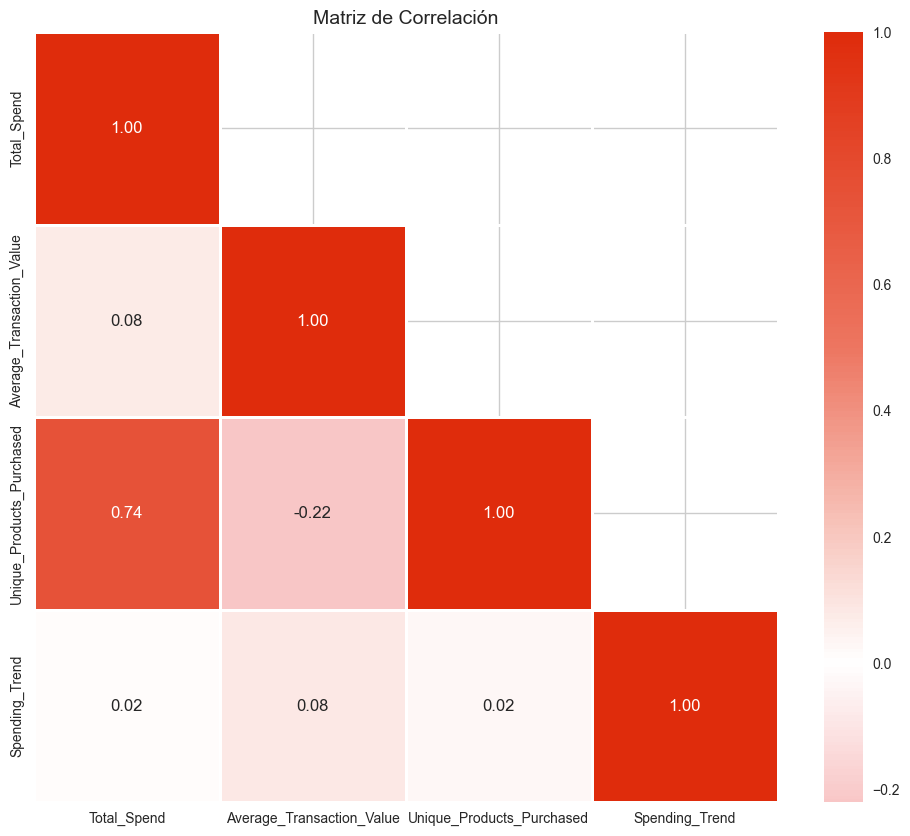

In [78]:
# Seleccionamos las columnas que quieres analizar
columns_to_analyze = [
  'Total_Spend',
  'Average_Transaction_Value',
  'Unique_Products_Purchased',
  'Spending_Trend'
]


# Filtramos el DataFrame para que contenga solo las columnas seleccionadas
df_filtered = customer_data_cleaned[columns_to_analyze]

# Calculamos la matriz de correlación solo para estas columnas
corr = df_filtered.corr()

# Definimos un colormap propio
colors = ['#CD5C5C', '#F08080', 'white', '#ed7661', '#DF2C0C']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Crear una máscara para mostrar solo el triángulo inferior de la matriz (ya que está reflejada alrededor de su diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Graficamos el heatmap
plt.figure(figsize=(12, 10))
sns.set_style('whitegrid')
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Matriz de Correlación', fontsize=14)
plt.show()

**Observaciones**:

- Estas altas correlaciones indican que, estas variables se mueven estrechamente juntas, lo que implica un grado de multicolinealidad.

> Antes de pasar a los siguientes pasos, considerando el impacto de la multicolinealed en el clustering de KMeans, podria ser beneficiosos tratar esta multicolinealidad posiblemente a traves de tecnicas de reduccion de dimensionalidad, como **PCA**, para crear un conjunto de variables no correlacionadas. Esto ayudara a lograr clusters mas estables durante el proceso de clustering de KMeans.

# Paso 7 | Escalado de Caracteristicas

Antes de seguir con el clustering y reduccion de dimensionalidad, tenemos que escalar las variables. Este pas tiene importancia, especialmente en el contexto de algoritmos como K-Means y Reduccion de Dimensionalidad como PCA:

  - **Para Clustering K-Means**:
    - K-Means se basa en gran medida en el concepto de *distancia* entre puntos de datos para formar clusteres.
    
    - Cuando las caracteristicas no estan en una escala similar, las caracteristicas con valores mas grandes pueden influir desproporcionadamente en el resultado del clustering, lo que potencialmente conduce a agrupamientos incorrectos.

  - **Para PCA**:
    - PCA busca encontrar las direcciones donde los datos varian mas.
    
    - Cuando las caracteristicas no estan escaladas, aquellas con valores mas grandes podrian dominar estos componentes, no reflejando con precision los patrones subyacentes en los datos.

In [79]:
# Inicializamos StandardScaler
scaler = StandardScaler()

# Columnas que no necesitan ser escaladas
columns_to_exlude = ['CustomerID']

# Columnas que si van a ser escaladas
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exlude)

# Crear una copia del dataset limpio
customer_data_scaled = customer_data_cleaned.copy()

# Aplicar el scaler a las columnas que van a ser escaladas
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Mostrar top 5 registros
customer_data_scaled.head()

,CustomerID,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Spending_Trend
0,1043,-0.636145,0.128018,-0.638406,-0.201903
1,1177,-0.570360,-0.395106,-0.476290,0.013670
2,1193,1.375221,-0.442211,3.227454,-0.018666
3,1196,-0.805343,-0.572162,-0.975110,-0.267222
4,1232,-0.425845,-0.170252,0.022531,-0.140150


# Paso 8 | Reduccion de la Dimensionalidad

> ¿Porque la Reduccion de Dimensionalidad?

  - **Multicolinealidad Detectada**:

    - En los pasos anteriores, identificamos que nuestro conjunto de datos contiene caracteristicas multicolineales.

    - La reduccion de dimensionalidad puede ayudarnos a eliminar informacion redundante y aliviar el problema de la multicolinealidad.

  - **Mejor Clustering con K-Means**:

    - Dado que K-Means es un algoritmo basado en la distancia, tener un gran numero de caracteristicas puede diluir los patrones en los datos.

    - Al reducir la dimensionalidad, podemos ayudar a K-Means a encontrar clusteres mas compactos y bien separados.

  - **Reduccion del Ruido**:
    - Al centrarnos solo en las caracteristicas mas importantes, podemos potencialmente eliminar el ruido en los datos, lo que lleva a clusteres mas precisos y estables.

  - **Mejora la Visualizacion**:
    - En este contexto, poder visualizar mejor los grupos de clientes en dos o tres dimensiones puede proporcionar intuiciones.

    - Las tecnicas de reduccion de dimensionalidad pueden facilitar esto al reducir los datos a unos pocos componentes principales que pueden ser facilmente graficados.

  - **Mejora la Eficiencia Computacional**:
    - Reducir el numero de caracteristicas puede acelerar el tiempo de calculo durante el proceso de modelado, haciendo que nuestro algoritmo de clustering sea mas eficiente.

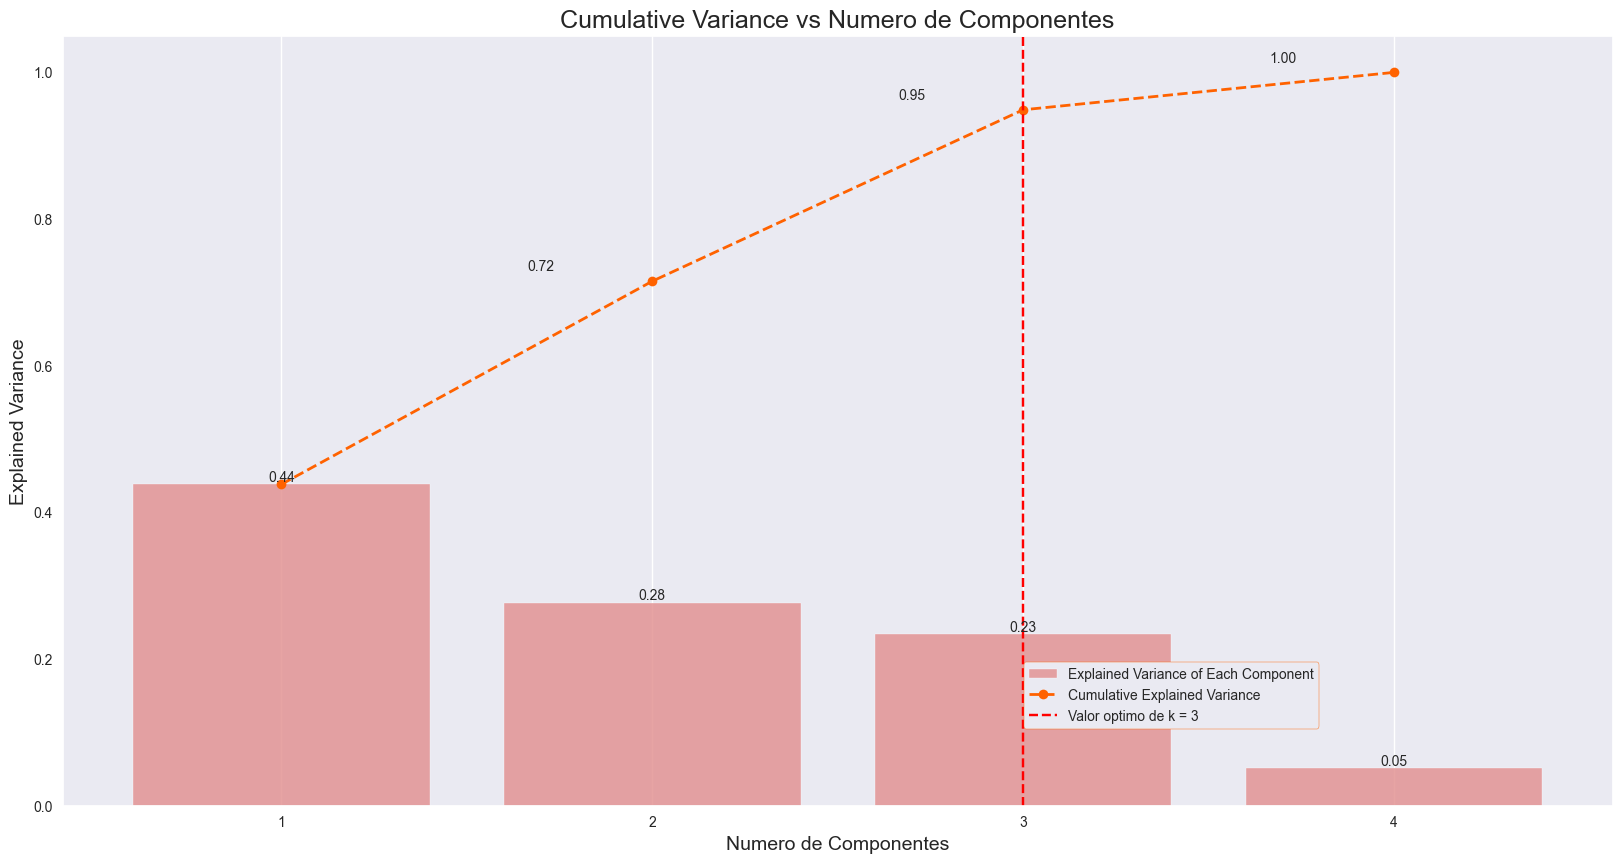

In [80]:
# Establecer CustomerID como el indice de las columnas
customer_data_scaled.set_index('CustomerID', inplace = True)

# Aplicar PCA
pca = PCA().fit(customer_data_scaled)

# Calcular la Cumulative Sum de la Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Establecer el valor de k
optimal_k = 3

# Graficar
sns.set_style('darkgrid')

# Graficar Cumulative Explained Varianza contra el numero de componentes
plt.figure(figsize = (20, 10))

# Grafico de barras para la Variance Explained por cada componente
barplot = sns.barplot(x = list(range(1, len(cumulative_explained_variance) + 1)), y = explained_variance_ratio, color = '#F08080', alpha = 0.8)

# Grafico lineal para la Cumulative Explained Variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance, marker = 'o', linestyle = '--', color = '#ff6200', linewidth = 2)

# Graficar la linea del valor de k optimo
optimal_k_line = plt.axvline(optimal_k - 1, color = 'red', linestyle = '--', label = f'Valor optimo de k = {optimal_k}')

# Establecer etiquetas y titulo
plt.xlabel('Numero de Componentes', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14)
plt.title('Cumulative Variance vs Numero de Componentes', fontsize = 18)

# Personalizar marcas y legenda
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles = [barplot.patches[0], lineplot, optimal_k_line], labels = ['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Valor optimo de k = {optimal_k}'], loc =(0.62, 0.1), frameon = True, framealpha = 1.0, edgecolor = '#ff6200')

# Mostrar los valores de la varianza para cada grafico
x_offset = -0.3
y_offset = 0.01

for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
  plt.text(i, ev_ratio, f'{ev_ratio:.2f}', ha = 'center', va = 'bottom', fontsize = 10)
  if i > 0:
    plt.text(i + x_offset, cum_ev_ratio + y_offset, f'{cum_ev_ratio:.2f}', ha = 'center', va = 'bottom', fontsize = 10)
    
plt.grid(axis = 'both')
plt.show()

**Conclusion**

El grafico y los valores de Cumulative Explained Variance indican cuanto de la varianza total en el conjunto de datos es capturada por cada componente principal, asi como la varianza acumulda explicada por los primero *n* componentes:

  - Aqui podemos observar que:
  
    - El primer componente explica aproximadamente el 31% de la varianza.

    - Los dos primeros componentes juntos explican alrededor del 46%.

    - Los tres primero componentes explican aproximadamente el 59% de la varianza, y asi sucesivamente.

Para elegir el numero optimo de componentes, generalmente buscamos un punto donde agregar otro componente no aumente significativamente la varianza explicada acumulada, a menudo referido como **elbow point** en la curva.

A apartir del `3 componente` comienza a desacelerarse (que captura el 95% del total de la varinza).

In [81]:
# Crear un PCA con 5 componentes
pca = PCA(n_components = 3)

# Ajustar y transformar los datos originales al nuevo dataframe de PCA
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Crear un nuevo dataframe a partir del dataframe de PCA, con etiquetadas como PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns = ['PC' + str(i + 1) for i in range(pca.n_components_)])

# Agregar el indice de CustomerID de nuevo al nuevo dataframe de PCA
customer_data_pca.index = customer_data_scaled.index


In [82]:
# Mostrar el dataframe resultante basado en los PCs
customer_data_pca.head()

,PC1,PC2,PC3
CustomerID,,,
1043,-0.914652,-0.110685,-0.141553
1177,-0.677625,-0.373242,0.327396
1193,3.307739,-0.287169,0.155127
1196,-1.177624,-0.694545,0.226838
1232,-0.256489,-0.301070,0.076691


Ahora, vamos a extraer los coeficientes correspondientes a cada componente principal para comprender mejor la transformacion realizada por PCA.

In [83]:
# Definir una funcion para resaltar los mejores 3 valores absolutos de cada columna del dataframe
def highlight_top3(column):
  top3 = column.abs().nlargest(3).index
  return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Crear el Dataframe de componentes de PCA y aplicar la funcion de resaltado
pc_df = pd.DataFrame(pca.components_.T, columns = ['PC{}'.format(i + 1) for i in range(pca.n_components_)], index = customer_data_scaled.columns)
pc_df.style.apply(highlight_top3, axis = 0)

,PC1,PC2,PC3
Total_Spend,0.686609,0.196998,-0.204313
Average_Transaction_Value,-0.135815,0.760184,-0.579176
Unique_Products_Purchased,0.713839,-0.065201,0.060318
Spending_Trend,0.023594,0.615679,0.786875


# Paso 9 | K-Means Clustering

## Paso 9.1 | Determinar el Numero Optimo de Clusteres

Para determinar el numero optimo de clusteres (k) para segmentar los clientes, explorare dos metodos conocidos:

  - **Elbow Method**

  - **Sihouette Method**

### Paso 9.1.1 | Elbow Method (*Metodo del Codo*)

*Que es el Elbow Method (Metodo del codo)*

  - Elbow Method es una tecnica para identificar el numero ideal de clusteres en un conjunto de datos.

  - Implica iterar a traves de los datos, generando clusteres para varios valores de k.

  - El algoritmo de K-Means calcula la suma de las distancias cuadradas entre cada puntode datos y su centroide de clusteres asignado, conocido como **inercia** o **puntaje WCSS**.

  - Al graficar el puntuaje de inercia contra el valor de k, creamos un grafico que tipicamente exhibe una forma de codo, de ahi su nombre.

  - El punto de codo representa el valor de k donde la reduccion de inercia lograda al aumentar k se vuelve insignificante, indicando el punto optimo de detencion para el numero de clusteres.

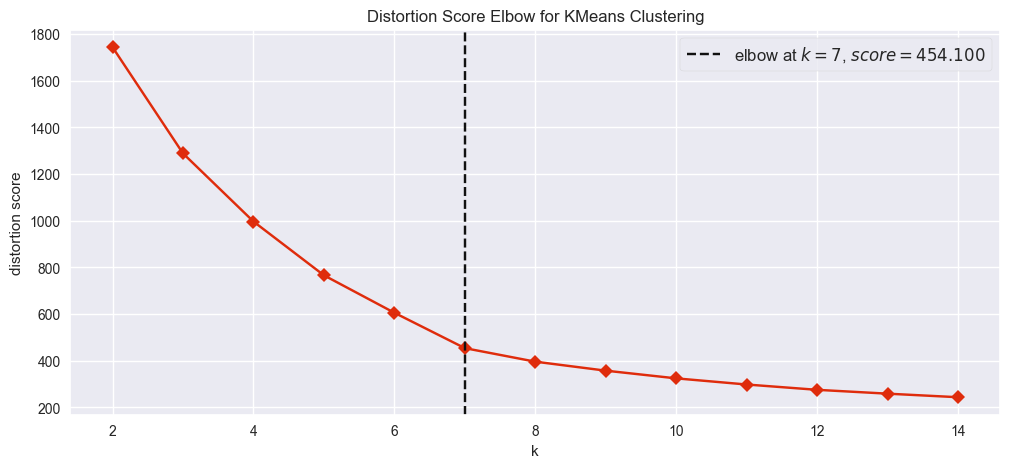

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [84]:
# Establecer estilo y color de fondo del grafico
sns.set_style('darkgrid')

# Establecer la paleta de colores del grafico
sns.set_palette(['#DF2C0C'])

# Instanciar el modelo de clustering con parametros especificos
kmean_model = KMeans(init = 'k-means++', n_init = 10, max_iter = 100, random_state = 0)

# Crear una figura
fig, ax = plt.subplots(figsize = (12, 5))

# Inicializar el KElbowVisualizer con el modelo y el ango de valores de k y desactivar la grafica de tiempos
visualizer = KElbowVisualizer(kmean_model, k = (2, 15), timings = False, ax = ax)

# Ajustar los datos al visualizador
visualizer.fit(customer_data_pca)

# Finalizar y renderizar la figura
visualizer.show()

**Valor optimo de k:** *Perspectivas del Metodo del Codo*

  - A partir del grafico, podemos ver que la inercia sigue disminuyendo significativamente hasta *k = 5*.

  - Para elegir el mejor k dentro de este rango, podemos emplear en analisis de silueta, otro metodo de evaluacion de la calidad de los clusteres.

### Paso 9.1.2 | Silhouette Method (*Metodo de la Silueta*)

*¿Qué es el Método de Silueta? (Metodo de la silueta)*

  - El Metodo de la Silueta es un enfoque para encontrar el numero optimo de clusteres en un conjunto de datos evaluando la consistencia dentro de los clusteres y su separacion de otros clusteres.

  - Calcula el coeficiente de silueta para cada punto de datos, que mide cuan similar es un punto a su propio cluster en comparacion con otros clusteres.

------------------------------------------------------------------------------

*¿Que es el Coeficiente de Silueta?*

  - El coeficiente de silueta cuantifica la similitud de un punto con su propio grupo (cohesion) en relacion con sus separacion de otros grupos. Este valor varia de -1 a 1, y los valores mas altos indican que el punto esta bien alineado con su grupo y tiene una baja similitud con los grupos vecinos

------------------------------------------------------------------------------

In [85]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
  # Configurar el tamaño de la figura del gráfico
  plt.figure(figsize=figsize)

  # Crear una cuadrícula con (stop_k - start_k + 1) filas y 2 columnas
  grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

  # Asignar la primera gráfica a la primera fila y ambas columnas
  first_plot = plt.subplot(grid[0, :])

  # Primera gráfica: Puntuaciones de Silueta para diferentes valores de k
  sns.set_palette(['darkorange'])

  silhouette_scores = []

  # Iterar a través del rango de valores de k
  for k in range(start_k, stop_k + 1):
    # Configurar el modelo KMeans con el número de clústeres actual
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
    # Ajustar el modelo KMeans a los datos
    km.fit(df)
    # Predecir las etiquetas de los clústeres para los datos
    labels = km.predict(df)
    # Calcular el puntaje de silueta para el modelo KMeans actual
    score = silhouette_score(df, labels)
    # Almacenar el puntaje de silueta en la lista
    silhouette_scores.append(score)

  # Encontrar el mejor valor de k basado en los puntajes de silueta
  best_k = start_k + silhouette_scores.index(max(silhouette_scores))

  # Graficar los puntajes de silueta para diferentes valores de k
  plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
  plt.xticks(range(start_k, stop_k + 1))
  plt.xlabel('Número de clústeres (k)')
  plt.ylabel('Puntuación de la Silueta')
  plt.title('Media de Puntuación de la Silueta para Diferentes Valores de k', fontsize=15)

  # Añadir el valor óptimo de k como texto en la gráfica
  optimal_k_text = f'El valor de k con la mayor puntuación de Silueta es: {best_k}'
  plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))

  # Segunda gráfica (subplot): Gráficos de Silueta para cada valor de k
  colors = sns.color_palette("bright")

  for i in range(start_k, stop_k + 1):    
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
    row_idx, col_idx = divmod(i - start_k, 2)

    # Asignar las gráficas a la segunda, tercera y cuarta filas
    ax = plt.subplot(grid[row_idx + 1, col_idx])

    visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
    visualizer.fit(df)

    # Añadir la puntuación de Silueta como texto en la gráfica
    score = silhouette_score(df, km.labels_)
    ax.text(0.97, 0.02, f'Puntuación de Silueta: {score:.2f}', fontsize=12, ha='right', transform=ax.transAxes, color='red')

    ax.set_title(f'Gráfico de Silueta para {i} Clústeres', fontsize=15)

  plt.tight_layout()
  plt.show()

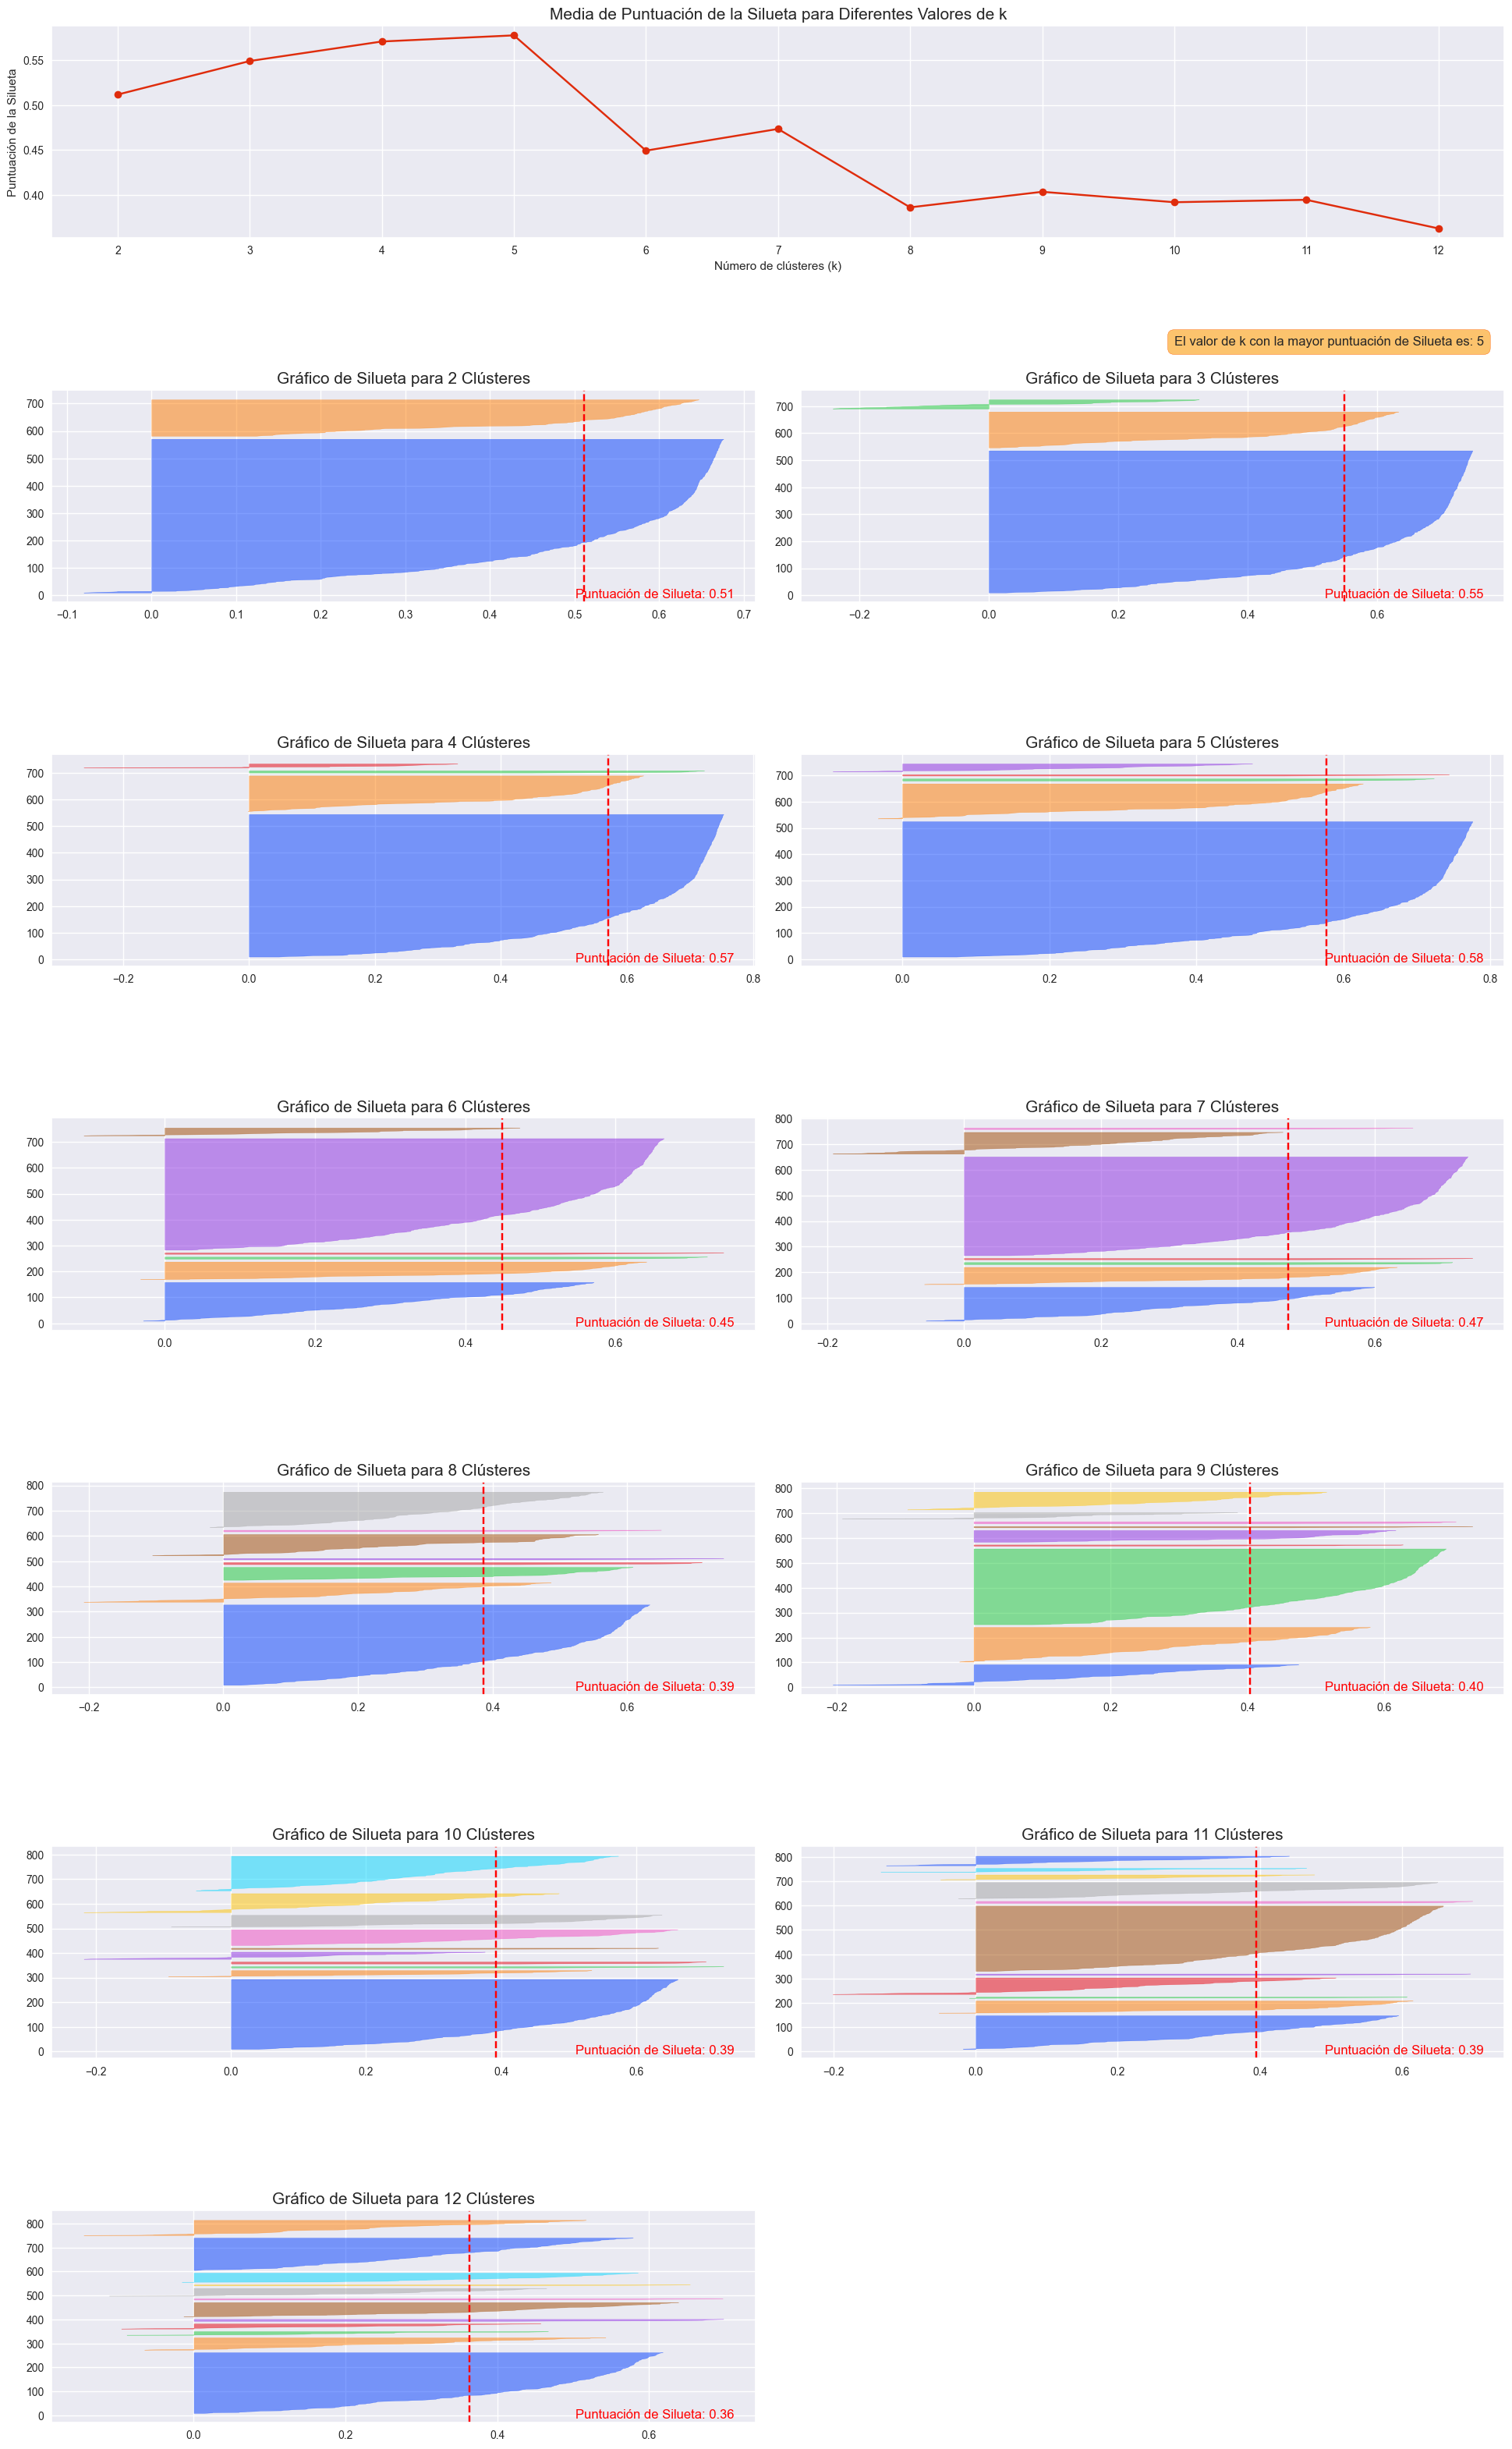

In [86]:
silhouette_analysis(customer_data_pca, 2, 12, figsize = (20, 50))

**Pautas para interpretar graficos de silueta y determinar el K optimo:**

Para interpretar los graficos de silueta e identificar el numero optimo de clusteres considera lo siguiente:

  - *__1. Analiza los graficos de silueta__*
  
    - **Ancho del puntuaje de silueta**

      - **Anchuras amplias (mas cercanas a +1)**:
        - Indican que los puntos de datos en el cluster estan bien separados de los puntos en otros clusters, sugiriendo cluster bien definidos.

      - **Anchuras estrechas (mas cercanas a -1)**:
        - Muestran que los puntos de datos en el cluster no estan separadas de otros clusteres, indicando clusteres mal definifos.

    - *__Puntuaje de Silueta promedio__*:

      - __Ancho promedio alto__: 
        - Un cluster con un puntuaje de silueta promedio alto indica clusteres bin separados.

      - __Ancho promedio bajo__:
        - Un cluster con un puntuaje de silueta promedio bajo indica una separacio deficiente entre clusteres.

-------------------------------------------

  - *__2. Uniformidad en el tamaño de los clusteres__*:

    - __Grosor del cluster__:
      
      - __Grosor uniforme__:
        - Indica que los clusteres tienen aproximadamente un numero igual de puntos de datos, lo que sugiere una estructura de clusteres equilibrada.

      - __Grosor variable__:
        - Indica in desequilibrio en la distribucion de puntos de datos entre los clusteres, con algunos clusterees que tienen muchos puntos de datos y otros pocos.

-------------------------------------------

  - *__3. Picos en el Puntuaje Promedio de silueta__*

    - __Picos Claros__:
      - In pico claro en el grafico del puntuaje promedio de silueta para un valore especifico de (k) indica que este (k) podria ser optimo.

-------------------------------------------

  - *__4. Minimizar las Fluctuaciones en los Anchos del Grafico de Silueta__*

    - __Anchos Unidormes__
      - Busca graficos de silueta con anchos similares entre los clusteres, lo que sugiere una agrupacion mas equilibrada y optimo.

    - __Anchos variables__
      - Evita grandes fluctuaciones en los anchos del grafico de silueta, ya que indican que los clusteres no estan bien definidos y pueden variar en compactacion.

-------------------------------------------

  - *__5. Seleccion Optima de Clusteres__*

    - __Maximixar el Puntuaje Promedio de Silueta General__:
      - Elige el valor de k que da el mejor puntuaje promedio de silueta mas alto en todos los clusteres, indicando clusteres bien definidos.

    - __Evitar Puntuajes de Silueta por Debajo del Promedio__:
      - Asegurate de que la mayoria de los clusteres tengan puntuajes de silueta por encima del promedio para evitar estructuras de clusteres suboptimas.

-------------------------------------------

  - *__6. Inspeccion Visual de los Graficos de Silueta__*

    - __Formacion Consistente de Clusteres__:
      - Inspecciona visualmente los graficos de silueta para cada valor de k para evaluar la consistencia y estructura de los clusteres formados.

    - __Compacidad de los Clusteres__:
      - Busca clusteres mas compactos, con puntos de datos que tengan puntuajes de silueta mas cercanos a +1, indicando una mejor agrupacion.

> En base a las pautas para obtener el valor optimo, es claro que **`k = 5`**

## Paso 9.2 | Modelo de Clustering - K-Means

  - Ahora voy a aplicar el algoritmo de clustering K-Means para segmentar a los clientes en diferenctes clusteres basados en sus comportamientos de compra y otras caracteristicas, utilizando el numero optimo de clusteres determinado en el paso anterior.

> Lo quiero pobar son las metricas en el rango de clusteres posibles

### `K-Means - Numero de clusters 5`

In [87]:
# Crear copia de customer_data_cleaned
customer_data_cleaned_k_5 = customer_data_cleaned.copy()

# Crear una copia de customer_data_pca
customer_data_pca_k_5 = customer_data_pca.copy()

In [88]:
# Aplicamos K-Means clustering usando el valor optimo de k
k_means = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 0)
k_means.fit(customer_data_pca_k_5)

# Obtenemos la frecuencia de cada cluster
cluster_frequency = Counter(k_means.labels_)

print(cluster_frequency)

Counter({0: 516, 1: 134, 4: 31, 2: 9, 3: 6})


- Es importante notar que el algoritmo K-Means podria asignar etiquetas diferentes en cada ejecucion. Para abordar eso, hemos tomado un paso adicional para intercambiar las etiquetas basandonos en la frecuencia de muestras en cada cluster.

- Asegurando una asignacion de etiquetas consistentes a traves de diferentes ejecuciones.

In [89]:
# Crear un mapeo de etiquetas antiguas a etiquetas nuevas basandonos en la frecuencia
label_mapping = {label : new_label for new_label, (label, _) in enumerate(cluster_frequency.most_common())}

# Invertir el mapeo para asignar etiquetas segun tu criterio
label_mapping = {v : k for k, v in {0:1, 1:2, 2:0, 3:3, 4:4}.items()}

# Aplicamos el mapeo para obtener las nevas etiquetas
new_labels = np.array([label_mapping[label] for label in k_means.labels_])

# Anexar las nuevas etiquetas de cluster de vuelta al conjunto de datos originales
customer_data_cleaned_k_5['cluster'] = new_labels

# Anexar las nuevas etiquetas de cluster a la version PCA del conjunto de datos
customer_data_pca_k_5['cluster'] = new_labels

In [90]:
# Mostras lor primeros registros de dataframe PCA
customer_data_pca_k_5.head()

,PC1,PC2,PC3,cluster
CustomerID,,,,
1043,-0.914652,-0.110685,-0.141553,2
1177,-0.677625,-0.373242,0.327396,2
1193,3.307739,-0.287169,0.155127,0
1196,-1.177624,-0.694545,0.226838,2
1232,-0.256489,-0.301070,0.076691,2


In [91]:
customer_data_cleaned_k_5.head()

,CustomerID,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Spending_Trend,cluster
0,1043,2042.444448,170.203704,63,-34.419648,2
1,1177,2800.383612,77.788434,89,-2.738431,2
2,1193,25216.48145,69.466891,683,-7.490647,0
3,1196,93.019094,46.509547,9,-44.019094,2
4,1232,4465.421295,117.511087,169,-25.344169,2


In [92]:
customer_data_cleaned_k_5['cluster'].value_counts()

cluster
2    516
0    134
4     31
1      9
3      6
Name: count, dtype: int64

# Paso 10 | Evaluacion del Clustering

## Paso 10.1 | Métricas de Evaluación

In [93]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Dividir el conjunto de entrenamiento y preba
X = customer_data_cleaned_k_5.drop(['cluster'], axis = 1)
y = customer_data_cleaned_k_5['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Crear el modelo KNN
knn = KNeighborsClassifier()

# Definir los valores de n_neighbors a probar
param_grid = {'n_neighbors': range(1, 31)}

# Configurar Grid Search con validación cruzada
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Ajustar el modelo a los datos
grid_search.fit(X, y)

# Mejor número de vecinos
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f'Mejor número de vecinos: {best_n_neighbors}')

Mejor número de vecinos: 29


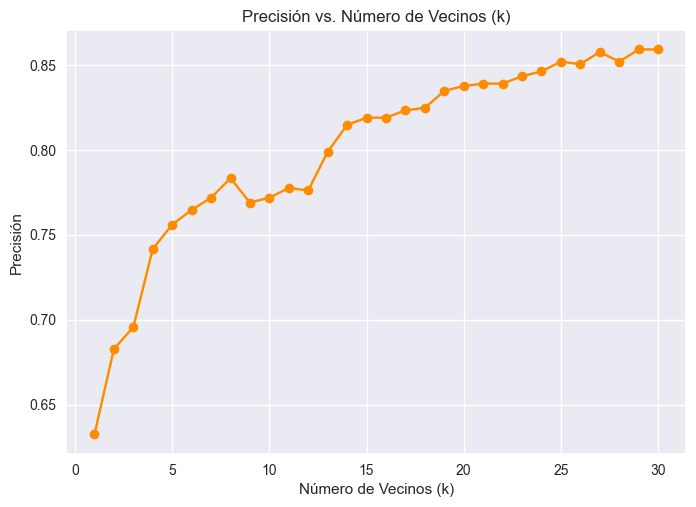

In [94]:
# Lista para almacenar las precisiones
accuracies = []

# Probar n_neighbors de 1 a 30
for k in range(1, 31):
  knn = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn, X, y, cv=5)
  accuracies.append(scores.mean())

# Graficar los resultados
plt.plot(range(1, 31), accuracies, marker='o')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Precisión')
plt.title('Precisión vs. Número de Vecinos (k)')
plt.show()

Precisión: 86.04%
Recall: 90.00%
F1 Score: 87.66%


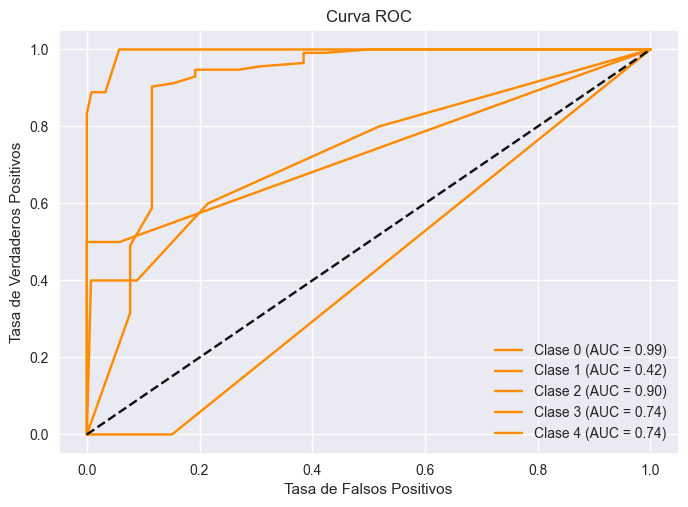

In [95]:
# Instancias el modelo KNN con el mejor numero de n_neighbors 
knn = KNeighborsClassifier(n_neighbors=29)

# Entrenar el modelo
knn.fit(X_train, y_train)

# Hacer predicciones
y_pred = knn.predict(X_test)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precisión: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Para calcular AUC-ROC, necesitamos las probabilidades de predicción
y_pred_proba = knn.predict_proba(X_test)

# Calcular la curva ROC y el AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(knn.classes_)

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC
plt.figure()
for i in range(n_classes):
  plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


## Paso 10.2 | Matriz de Confusion

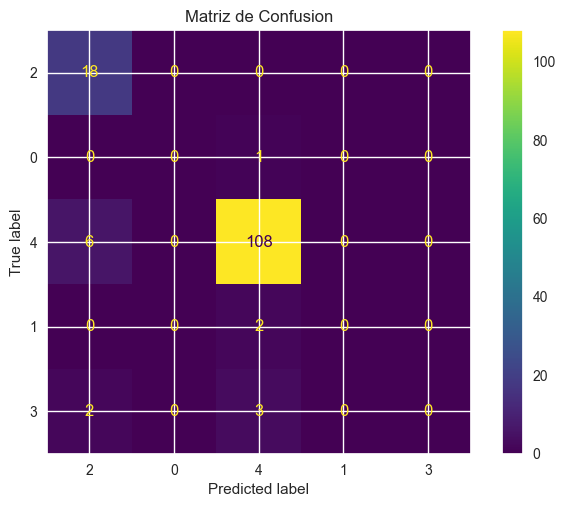

In [96]:
# Crear la matriz de confusion
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusion
cluster_labels = customer_data_cleaned_k_5['cluster'].unique()
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = cluster_labels)
disp.plot(cmap = 'viridis')
plt.title('Matriz de Confusion')
plt.show()

- Despues de determinar el numero optimo de clusteres (5 en nuestro caso), toca realizar la evaluacion de calidad de clusteres formados.

- Este paso es esencial para validad la efectividad del clustering y asegurar que los clusteres sean coherentes y esten bien separados.

- Las metricas de evaluacion y la tecnica de visualizacion las describo a continuacion:



## Paso 10.3 | Visualizavion de la Distribucion de Clusteres

### Paso 10.3.1 | Visualizacion 3D de los Principales 5 Componentes

In [97]:
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']

# Crear dataFrames separados por cada cluster
cluster_0 = customer_data_pca_k_5[customer_data_pca_k_5['cluster'] == 0]
cluster_1 = customer_data_pca_k_5[customer_data_pca_k_5['cluster'] == 1]
cluster_2 = customer_data_pca_k_5[customer_data_pca_k_5['cluster'] == 2]
cluster_3 = customer_data_pca_k_5[customer_data_pca_k_5['cluster'] == 3]
cluster_4 = customer_data_pca_k_5[customer_data_pca_k_5['cluster'] == 4]

# Crear el Grafico 3D
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))
fig.add_trace(go.Scatter3d(x=cluster_3['PC1'], y=cluster_3['PC2'], z=cluster_3['PC3'], mode='markers', marker=dict(color=colors[3], size=5, opacity=0.4), name='Cluster 3'))
fig.add_trace(go.Scatter3d(x=cluster_4['PC1'], y=cluster_4['PC2'], z=cluster_4['PC3'], mode='markers', marker=dict(color=colors[4], size=5, opacity=0.4), name='Cluster 4'))

# Establecer textos
fig.update_layout(
  title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
  scene=dict(
      xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
      yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
      zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
  ),
  width=900,
  height=800
)

# Mostrar el grafico
fig.show()


## Paso 10.4 | Visualizacion de la Distribucion de los Clusteres

In [98]:
# Calcular el porcentaje de clientes en cada cluster
cluster_percentage = (customer_data_pca_k_5['cluster'].value_counts(normalize = True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Porcentaje']
cluster_percentage.sort_values(by = 'Cluster', inplace = True)

# Crear grafico de barras horizontales
fig = px.bar(
  cluster_percentage,
  x = 'Porcentaje',
  y = 'Cluster',
  orientation = 'h',
  text = 'Porcentaje',
  color = 'Cluster',
  color_discrete_sequence = colors
)

# # Actualizar el dise;o para ajustar los porcentajes
fig.update_traces(texttemplate = '%{text:.2f}%', textposition = 'outside')

# Agregar titulo y ajustar etiquetas
fig.update_layout(
  title = 'Distribucion de los Clientes en los CLusteres',
  xaxis_title = 'Porcentaje (%)',
  yaxis_title = 'Cluster',
  xaxis = dict(tickvals = list(range(0, 51, 5))),
  height = 400,
)

fig.show()

## Paso 10.5 | Metricas de Evaluacion

Para analizar mas a fondo la calidad de nuestro clustering, usare las siguientes metricas:

  - __Silhouette Score__:
    - Una medida para evaluar la distancia de separacion entre los clusteres.

    - Los valores mas altos indican una mejor separacion entre los clusteres. Varia de -1 a 1.
  
  - __Calinski Harabasz Score__:
    - Esta puntuacion se usa para evaluar la dispersion entre y dentro de los clusteres.
    - Una puntuacion mas alta indica clusteres mejor definidos

  - __Davies Bouldin Score__:
    - Evalua la similitud promedio entre cada cluster y su cluster mas similar.
    - Los valores mas bajos indican una mejor separacion entre los clusteres.


### Metricas con `K = 5`

In [99]:
# Calcular en numero de observaciones
num_observations = len(customer_data_pca_k_5)

# Separar las caracteristicas y las etiquetas de los clusteres
X = customer_data_pca_k_5.drop('cluster', axis = 1)
clusters = customer_data_pca_k_5['cluster']

# Calcular las metricas
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Crear una tabla para mostrar las metrica
table_data = [
  ['Numero de observaciones', num_observations],
  ['Puntuacion de Silueta', sil_score],
  ['Puntuacion de Calinski Harabasz', calinski_score],
  ['Puntuacion de Davies Bouldin', davies_score],
]

# Mostrar la tabla
print(tabulate(table_data, headers = ['Metric', 'Score'], tablefmt = 'pretty'))

+---------------------------------+--------------------+
|             Metric              |       Score        |
+---------------------------------+--------------------+
|     Numero de observaciones     |        696         |
|      Puntuacion de Silueta      | 0.5774461472446228 |
| Puntuacion de Calinski Harabasz |  422.988939928138  |
|  Puntuacion de Davies Bouldin   | 0.6344649611114094 |
+---------------------------------+--------------------+


# Paso 11 | Analisis del Cluster y Perfilado

## Paso 11.1 | Grafico de Radar

In [100]:
# Establecer la columna `CustomerID` como indice y asignarla a un nuevo dataframe
df_customer = customer_data_cleaned_k_5.set_index('CustomerID')

# Estandarizar los datos (excluyendo la columna de clusters)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns = ['cluster'], axis = 1))

# Crear un nuevo dataframe con los valores estandarizados y agregar la columna cluster nuevamente
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns = df_customer.columns[:-1], index = df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calcular los centroides de cada cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Establecer los datos
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Crear subplots, uno por cada cluster
fig = make_subplots(
    rows=1, cols=cluster_centroids.shape[0],  # Una fila, tantas columnas como clusters
    subplot_titles=[f'Cluster {i}' for i in cluster_centroids.index],  # Títulos de los subplots
    specs=[[{'type': 'polar'} for _ in range(cluster_centroids.shape[0])]],  # Especificar que cada subplot es de tipo 'polar'
)

# Crear un gráfico de radar para cada cluster en subplots separados
for i, cluster in enumerate(cluster_centroids.index):
    # Datos del cluster actual
    data = cluster_centroids.loc[cluster].tolist()

    # Añadir traza (trace) al subplot correspondiente
    fig.add_trace(
        go.Scatterpolar(
            r=data,  # Valores del cluster
            theta=labels,  # Etiquetas
            fill='toself',  # Rellenar el área
            name=f'Cluster {cluster}',  # Nombre del cluster
            line=dict(color=colors[i])  # Color de la línea
        ),
        row=1, col=i+1  # Ubicar en la fila 1 y columna correspondiente
    )

# Ajustar el diseño del gráfico
fig.update_layout(
    height=500,  # Ajusta la altura del gráfico
    width=1200,  # Ajusta el ancho del gráfico
    title_text='Radar Chart para Cada Cluster',  # Título general
    showlegend=False  # No mostrar la leyenda (ya que hay títulos para cada subplot)
)

# Mostrar el gráfico
fig.show()
